# Stochastic Gradient Descent with Learning Rate Schedules and Regularization

## Imports

In [3]:
import numpy as np
from sklearn.model_selection import *
from src.data import *
from src.helpers import test_model_performance, plot_performance_metrics

## Structure of SGD

In [1]:
class SGD:
    """Стохастический градиентный спуск для задач регрессии."""

    def __init__(self, learning_rate=0.01, epochs=100, batch_size=32,
                 regularization=None, reg_param=0.01, lr_schedule=None,
                 momentum=0.0, early_stopping=False, patience=10,
                 verbose=False, random_state=None):
        """
        Инициализация SGD с настройками

        Параметры:
        learning_rate : начальная скорость обучения
        epochs : количество эпох обучения
        batch_size : размер мини-батча
        regularization : тип регуляризации ('l1', 'l2', 'elasticnet')
        reg_param : параметр регуляризации (lambda)
        lr_schedule : график скорости обучения ('constant', 'time_decay', 'step_decay', 'exponential')
        momentum : коэффициент импульса (0 - без импульса)
        early_stopping : использовать раннюю остановку
        patience : количество эпох без улучшения для ранней остановки
        verbose : выводить информацию о процессе обучения
        random_state : значение для воспроизводимости результатов
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.regularization = regularization
        self.reg_param = reg_param
        self.lr_schedule = lr_schedule
        self.momentum = momentum
        self.early_stopping = early_stopping
        self.patience = patience
        self.verbose = verbose

        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

        self.weights = None
        self.bias = None
        self.velocity_w = None
        self.velocity_b = None

        self.loss_history = []
        self.val_loss_history = []
        self.best_weights = None
        self.best_bias = None
        self.best_val_loss = float('inf')
        self.best_epoch = 0

    def _initialize_parameters(self, n_features):
        """Инициализация весов и смещения"""
        # Инициализация Xavier для лучшей сходимости
        limit = np.sqrt(6 / (n_features + 1))
        self.weights = self.rng.uniform(-limit, limit, n_features)
        self.bias = 0.0

        # Инициализация для импульса
        self.velocity_w = np.zeros(n_features)
        self.velocity_b = 0.0

        # Для early stopping
        self.best_weights = self.weights.copy()
        self.best_bias = self.bias

    def _get_learning_rate(self, epoch):
        """Расчет скорости обучения в зависимости от графика"""
        if self.lr_schedule is None or self.lr_schedule == 'constant':
            return self.learning_rate

        if self.lr_schedule == 'time_decay':
            decay_rate = 0.01
            return self.learning_rate / (1 + decay_rate * epoch)

        if self.lr_schedule == 'step_decay':
            drop = 0.5
            epochs_drop = 10
            return self.learning_rate * np.power(drop, np.floor(epoch / epochs_drop))

        if self.lr_schedule == 'exponential':
            decay_rate = 0.01
            return self.learning_rate * np.exp(-decay_rate * epoch)

        return self.learning_rate

    def _apply_regularization(self, weights, gradient):
        """Применение регуляризации к градиенту"""
        if self.regularization is None:
            return gradient

        if self.regularization == 'l2':
            return gradient + self.reg_param * weights

        if self.regularization == 'l1':
            return gradient + self.reg_param * np.sign(weights)

        if self.regularization == 'elasticnet':
            l1_ratio = 0.5
            l1_contrib = self.reg_param * l1_ratio * np.sign(weights)
            l2_contrib = self.reg_param * (1 - l1_ratio) * weights
            return gradient + l1_contrib + l2_contrib

        return gradient

    def _compute_gradient(self, X_batch, y_batch):
        """Вычисление градиента для мини-батча"""
        m = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias  # оптимизировано
        errors = predictions - y_batch

        # Оптимизированное вычисление градиента
        dw = (X_batch.T @ errors) / m
        db = np.mean(errors)

        # Применение регуляризации только к весам
        dw = self._apply_regularization(self.weights, dw)

        return dw, db

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Обучение модели на данных
        """
        X = np.asarray(X)
        y = np.asarray(y)

        if X_val is not None:
            X_val = np.asarray(X_val)
            y_val = np.asarray(y_val)
            use_validation = True
        else:
            use_validation = False

        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)

        self.loss_history = []
        self.val_loss_history = []
        no_improvement_count = 0

        for epoch in range(self.epochs):
            # Перемешиваем данные на каждой эпохе
            indices = self.rng.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Текущая скорость обучения
            current_lr = self._get_learning_rate(epoch)

            # Мини-батч SGD
            for i in range(0, n_samples, self.batch_size):
                end_idx = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]

                # Вычисление градиентов
                dw, db = self._compute_gradient(X_batch, y_batch)

                # Обновление с использованием импульса
                self.velocity_w = self.momentum * self.velocity_w - current_lr * dw
                self.velocity_b = self.momentum * self.velocity_b - current_lr * db

                # Обновление параметров
                self.weights += self.velocity_w
                self.bias += self.velocity_b

            # Расчет ошибки на обучающей выборке
            train_predictions = X @ self.weights + self.bias
            train_loss = np.mean((train_predictions - y) ** 2)
            self.loss_history.append(train_loss)

            # Расчет ошибки на валидационной выборке
            if use_validation:
                val_predictions = X_val @ self.weights + self.bias
                val_loss = np.mean((val_predictions - y_val) ** 2)
                self.val_loss_history.append(val_loss)

                # Сохраняем лучшие веса
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.best_weights = self.weights.copy()
                    self.best_bias = self.bias
                    self.best_epoch = epoch
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

            # Вывод прогресса
            if self.verbose and (epoch + 1) % 10 == 0:
                status = f"Эпоха {epoch + 1}/{self.epochs}, loss: {train_loss:.6f}"
                if use_validation:
                    status += f", val_loss: {val_loss:.6f}"
                print(status)

            # Ранняя остановка
            if self.early_stopping and use_validation and no_improvement_count >= self.patience:
                if self.verbose:
                    print(f"Ранняя остановка на эпохе {epoch + 1}")
                # Восстанавливаем лучшие веса
                self.weights = self.best_weights
                self.bias = self.best_bias
                break

        # Восстанавливаем лучшие веса в конце обучения
        if use_validation:
            self.weights = self.best_weights
            self.bias = self.best_bias

        return self

    def predict(self, X):
        """Выполнение прогноза"""
        X = np.asarray(X)
        return X @ self.weights + self.bias

[I 2025-05-20 19:18:59,336] A new study created in memory with name: no-name-ddd94cbd-b47c-43ae-96fe-b29637cb3343


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:00,636] Trial 0 finished with value: 8.505151279458572e+95 and parameters: {}. Best is trial 0 with value: 8.505151279458572e+95.
[I 2025-05-20 19:19:00,727] Trial 1 finished with value: 24830.18031226996 and parameters: {}. Best is trial 1 with value: 24830.18031226996.
[I 2025-05-20 19:19:00,775] Trial 2 finished with value: 0.5573062497003107 and parameters: {}. Best is trial 2 with value: 0.5573062497003107.
[I 2025-05-20 19:19:00,807] Trial 3 finished with value: 0.555761106604859 and parameters: {}. Best is trial 3 with value: 0.555761106604859.
[I 2025-05-20 19:19:00,827] Trial 4 finished with value: 0.5495898556323052 and parameters: {}. Best is trial 4 with value: 0.5495898556323052.
[I 2025-05-20 19:19:00,844] Trial 5 finished with value: 0.5537624633938246 and parameters: {}. Best is trial 4 with value: 0.5495898556323052.
[I 2025-05-20 19:19:00,863] Trial 6 finished with value: 0.7792215755288016 and parameters: {}. Best is trial 4 with value: 0.54958985

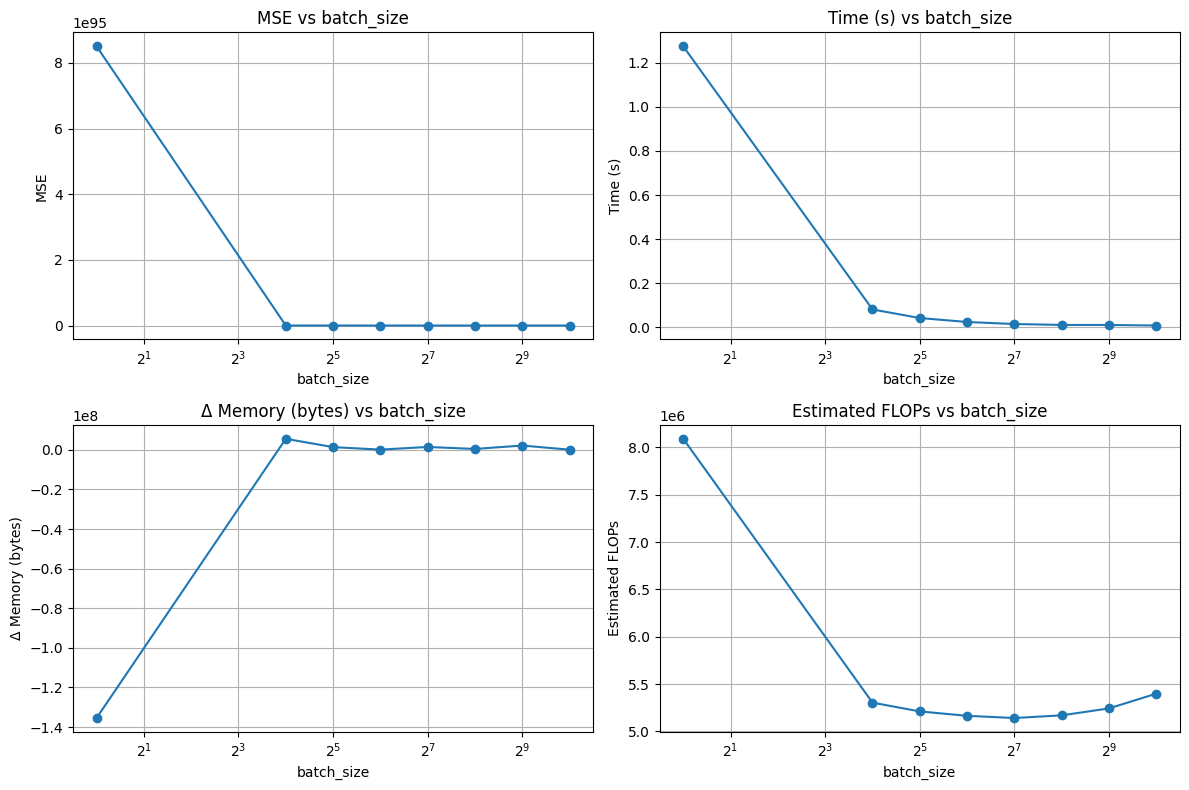

[I 2025-05-20 19:19:02,766] A new study created in memory with name: no-name-d3445598-83c7-4b26-ac2d-4cdfa3213606


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:04,050] Trial 0 finished with value: 1.1009867568687714e+92 and parameters: {}. Best is trial 0 with value: 1.1009867568687714e+92.
[I 2025-05-20 19:19:04,139] Trial 1 finished with value: 8008.415911897779 and parameters: {}. Best is trial 1 with value: 8008.415911897779.
[I 2025-05-20 19:19:04,188] Trial 2 finished with value: 0.5470794134166803 and parameters: {}. Best is trial 2 with value: 0.5470794134166803.
[I 2025-05-20 19:19:04,218] Trial 3 finished with value: 0.5572730395673267 and parameters: {}. Best is trial 2 with value: 0.5470794134166803.
[I 2025-05-20 19:19:04,239] Trial 4 finished with value: 0.5553117120575173 and parameters: {}. Best is trial 2 with value: 0.5470794134166803.
[I 2025-05-20 19:19:04,256] Trial 5 finished with value: 0.5663706120331535 and parameters: {}. Best is trial 2 with value: 0.5470794134166803.
[I 2025-05-20 19:19:04,274] Trial 6 finished with value: 0.5957961133000592 and parameters: {}. Best is trial 2 with value: 0.5470

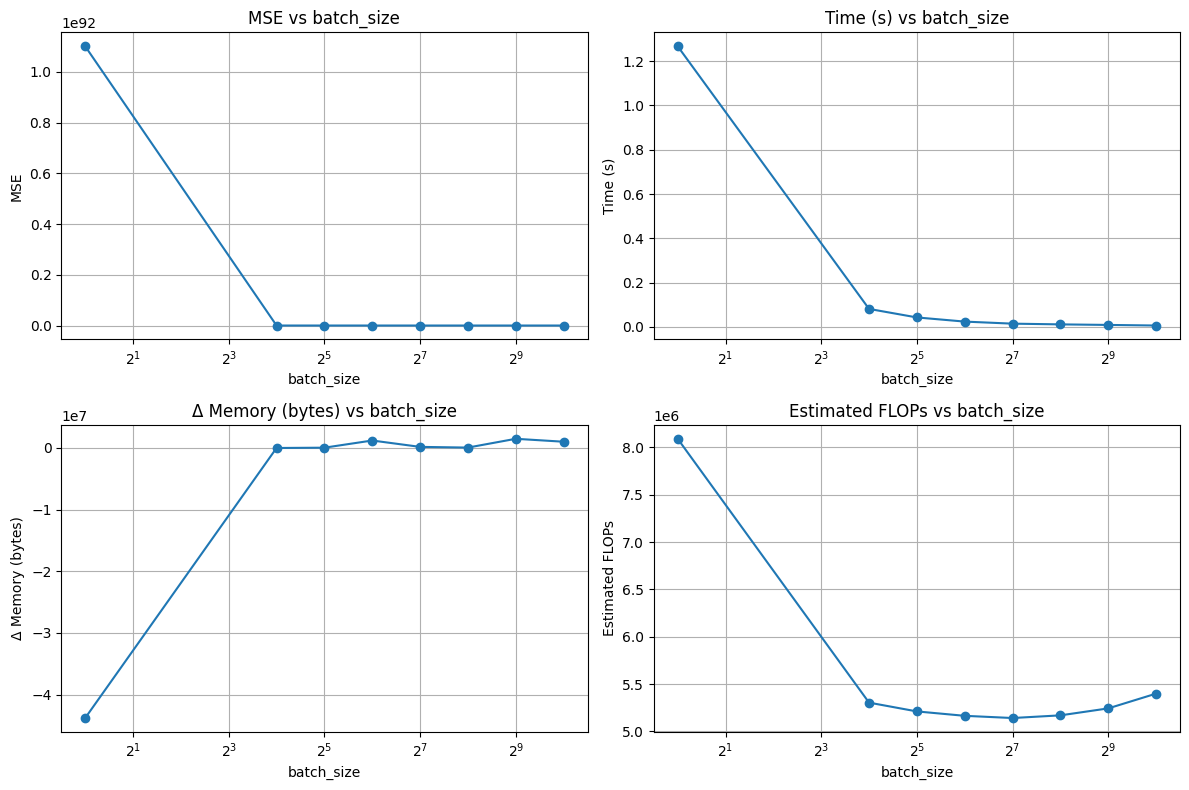

[I 2025-05-20 19:19:06,014] A new study created in memory with name: no-name-2a354389-9417-4a08-aaaf-9e08eb1fab0a


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:07,273] Trial 0 finished with value: 2.6587211001365906e+95 and parameters: {}. Best is trial 0 with value: 2.6587211001365906e+95.
[I 2025-05-20 19:19:07,362] Trial 1 finished with value: 43.10123784493158 and parameters: {}. Best is trial 1 with value: 43.10123784493158.
[I 2025-05-20 19:19:07,411] Trial 2 finished with value: 0.5459200576404946 and parameters: {}. Best is trial 2 with value: 0.5459200576404946.
[I 2025-05-20 19:19:07,442] Trial 3 finished with value: 0.5575098658840535 and parameters: {}. Best is trial 2 with value: 0.5459200576404946.
[I 2025-05-20 19:19:07,462] Trial 4 finished with value: 0.5706275362180089 and parameters: {}. Best is trial 2 with value: 0.5459200576404946.
[I 2025-05-20 19:19:07,477] Trial 5 finished with value: 0.6309820824871918 and parameters: {}. Best is trial 2 with value: 0.5459200576404946.
[I 2025-05-20 19:19:07,498] Trial 6 finished with value: 0.6521640298317943 and parameters: {}. Best is trial 2 with value: 0.5459

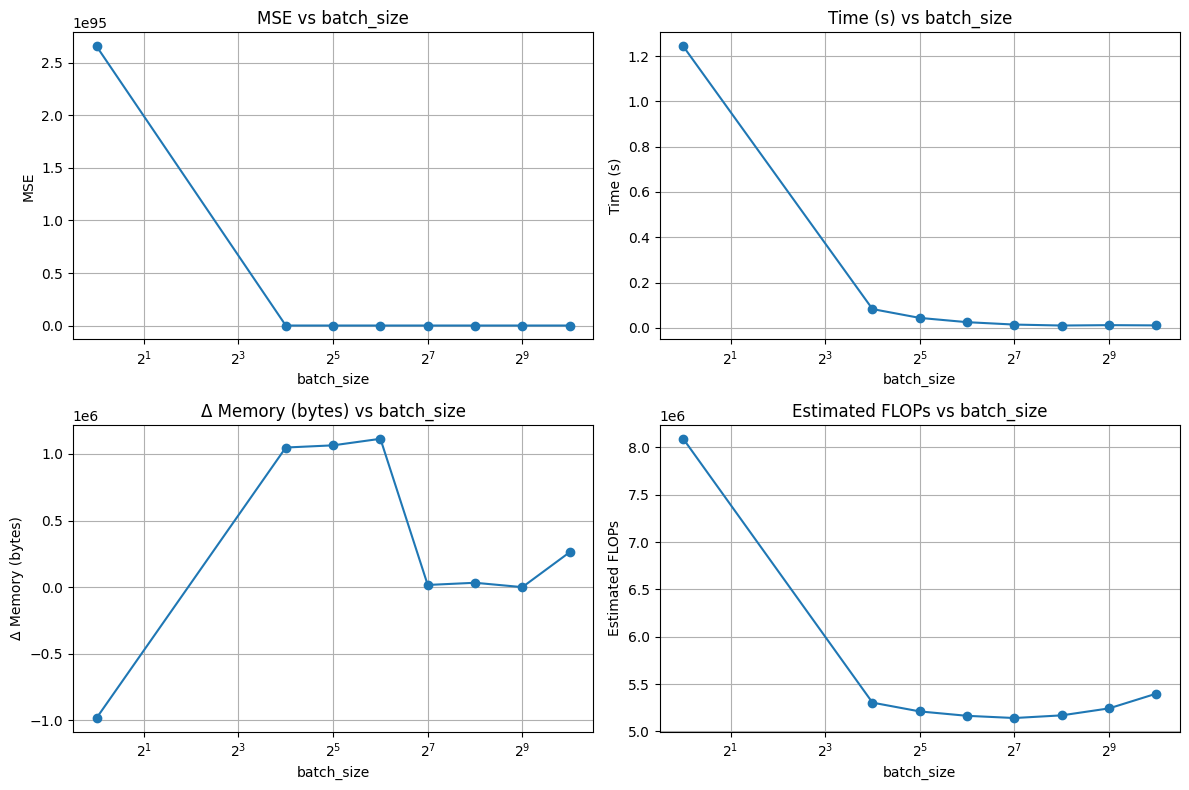

[I 2025-05-20 19:19:09,306] A new study created in memory with name: no-name-9f30b10c-05e5-4223-bbfc-2ae72edf2fbd


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:10,562] Trial 0 finished with value: 7.664586582046282e+94 and parameters: {}. Best is trial 0 with value: 7.664586582046282e+94.
[I 2025-05-20 19:19:10,649] Trial 1 finished with value: 2100.0570092095395 and parameters: {}. Best is trial 1 with value: 2100.0570092095395.
[I 2025-05-20 19:19:10,708] Trial 2 finished with value: 0.5489190032423433 and parameters: {}. Best is trial 2 with value: 0.5489190032423433.
[I 2025-05-20 19:19:10,738] Trial 3 finished with value: 0.5540924780217367 and parameters: {}. Best is trial 2 with value: 0.5489190032423433.
[I 2025-05-20 19:19:10,757] Trial 4 finished with value: 0.55894022320998 and parameters: {}. Best is trial 2 with value: 0.5489190032423433.
[I 2025-05-20 19:19:10,777] Trial 5 finished with value: 0.6149458450418775 and parameters: {}. Best is trial 2 with value: 0.5489190032423433.
[I 2025-05-20 19:19:10,795] Trial 6 finished with value: 0.5618960247240087 and parameters: {}. Best is trial 2 with value: 0.548919

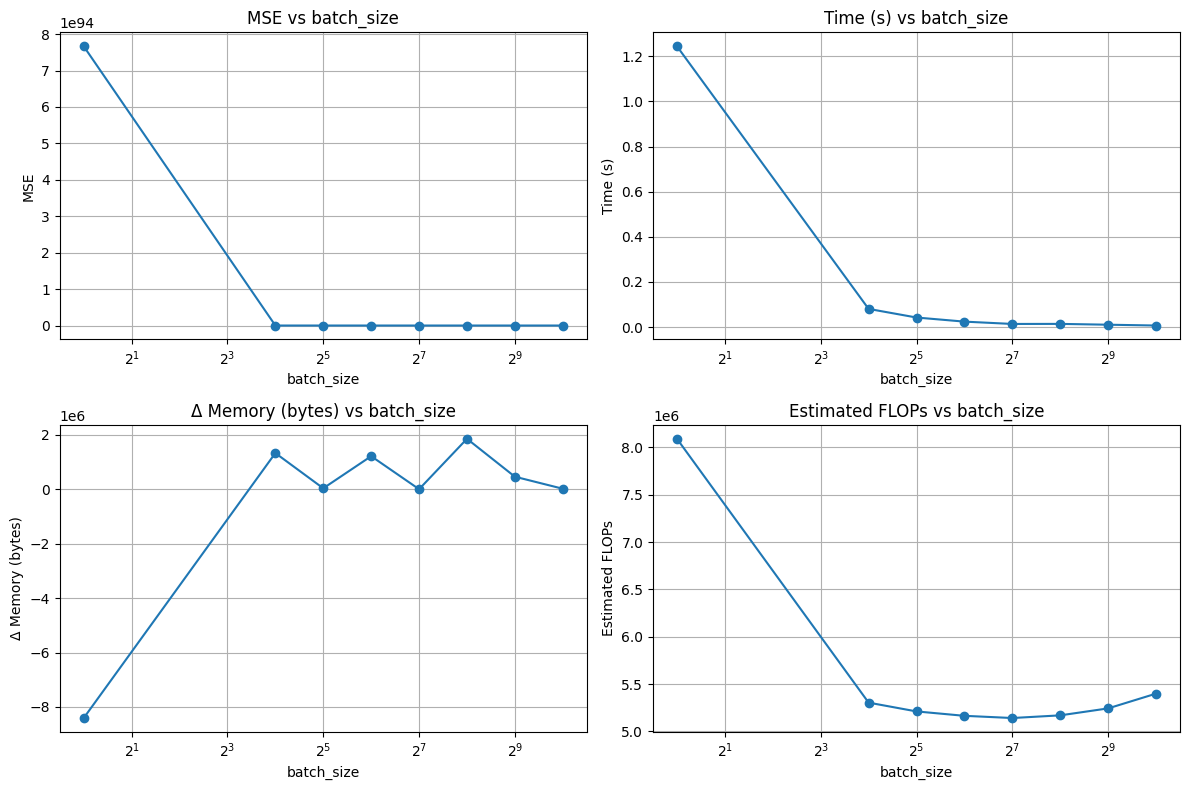

[I 2025-05-20 19:19:12,438] A new study created in memory with name: no-name-a6f10e7d-c139-4ace-abaf-3a508b084a97


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:13,638] Trial 0 finished with value: 1.0161289167093242e+80 and parameters: {}. Best is trial 0 with value: 1.0161289167093242e+80.
[I 2025-05-20 19:19:13,724] Trial 1 finished with value: 2472.247720366944 and parameters: {}. Best is trial 1 with value: 2472.247720366944.
[I 2025-05-20 19:19:13,771] Trial 2 finished with value: 0.5720719616085156 and parameters: {}. Best is trial 2 with value: 0.5720719616085156.
[I 2025-05-20 19:19:13,801] Trial 3 finished with value: 0.5689044116451769 and parameters: {}. Best is trial 3 with value: 0.5689044116451769.
[I 2025-05-20 19:19:13,820] Trial 4 finished with value: 0.5897543425400363 and parameters: {}. Best is trial 3 with value: 0.5689044116451769.
[I 2025-05-20 19:19:13,836] Trial 5 finished with value: 0.6339095504826087 and parameters: {}. Best is trial 3 with value: 0.5689044116451769.
[I 2025-05-20 19:19:13,853] Trial 6 finished with value: 0.8611564132580392 and parameters: {}. Best is trial 3 with value: 0.5689

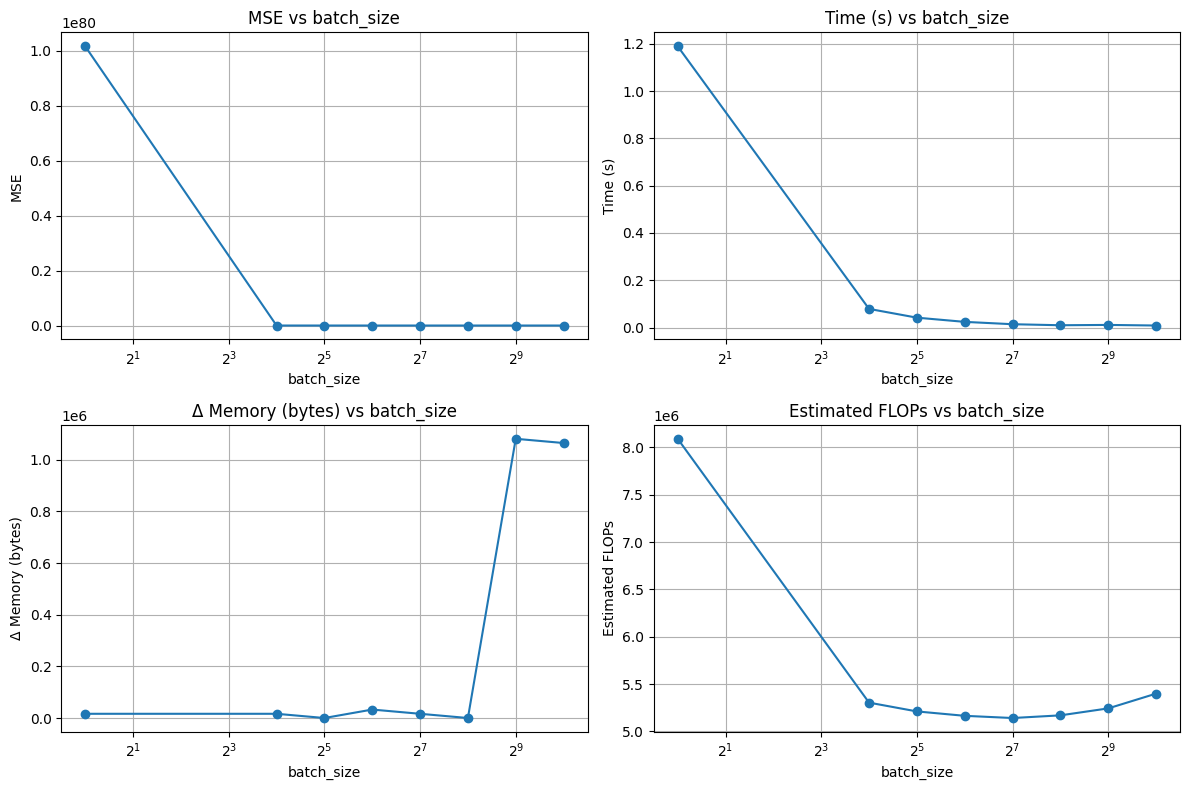

[I 2025-05-20 19:19:15,615] A new study created in memory with name: no-name-5b34e70a-3d1c-49c3-99c7-7e935ea059b9


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:16,824] Trial 0 finished with value: 3.8189240911662914e+80 and parameters: {}. Best is trial 0 with value: 3.8189240911662914e+80.
[I 2025-05-20 19:19:16,916] Trial 1 finished with value: 107.8457305963828 and parameters: {}. Best is trial 1 with value: 107.8457305963828.
[I 2025-05-20 19:19:16,964] Trial 2 finished with value: 0.5685678482970428 and parameters: {}. Best is trial 2 with value: 0.5685678482970428.
[I 2025-05-20 19:19:16,995] Trial 3 finished with value: 0.5540642164566205 and parameters: {}. Best is trial 3 with value: 0.5540642164566205.
[I 2025-05-20 19:19:17,014] Trial 4 finished with value: 0.589757675032993 and parameters: {}. Best is trial 3 with value: 0.5540642164566205.
[I 2025-05-20 19:19:17,031] Trial 5 finished with value: 0.6223632588940471 and parameters: {}. Best is trial 3 with value: 0.5540642164566205.
[I 2025-05-20 19:19:17,049] Trial 6 finished with value: 0.5789514505991359 and parameters: {}. Best is trial 3 with value: 0.55406

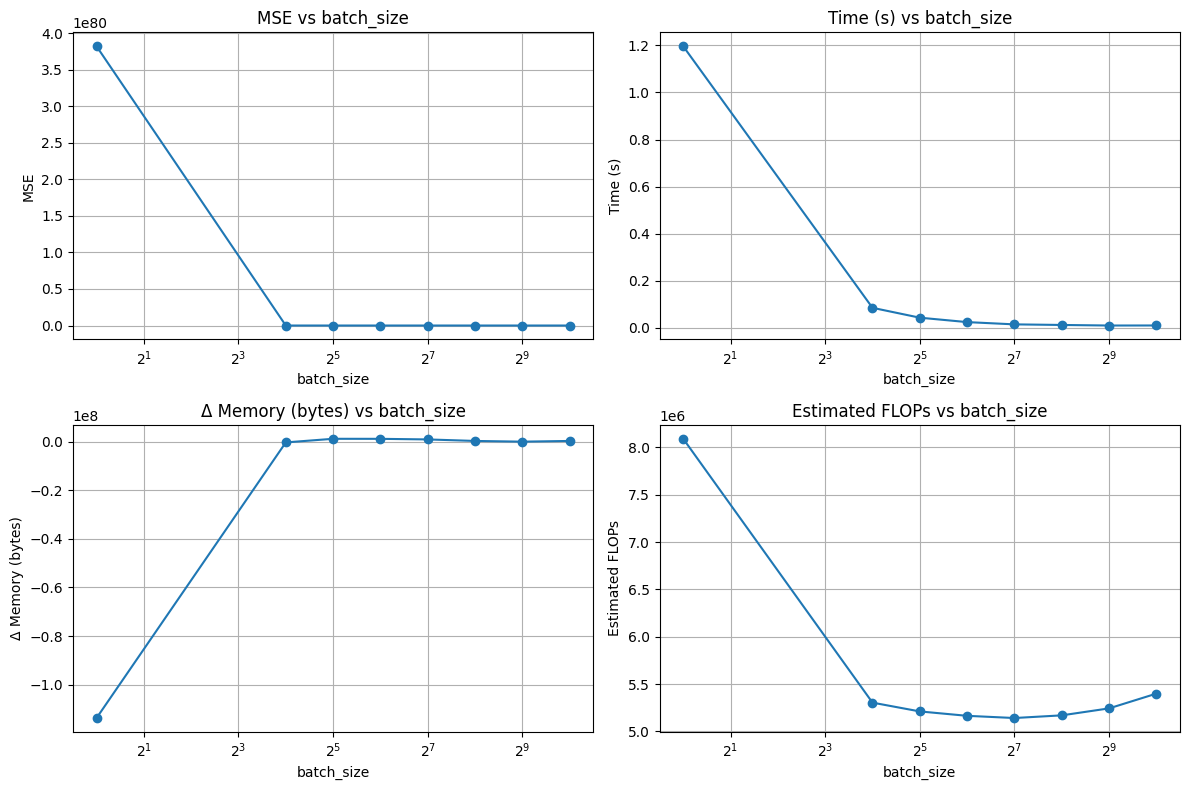

[I 2025-05-20 19:19:18,705] A new study created in memory with name: no-name-02e961a3-a4d9-41b1-b4ff-12d5b674c88a


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:19,908] Trial 0 finished with value: 3.891434891517906e+81 and parameters: {}. Best is trial 0 with value: 3.891434891517906e+81.
[I 2025-05-20 19:19:19,994] Trial 1 finished with value: 3499.90259061135 and parameters: {}. Best is trial 1 with value: 3499.90259061135.
[I 2025-05-20 19:19:20,041] Trial 2 finished with value: 0.5551660906956426 and parameters: {}. Best is trial 2 with value: 0.5551660906956426.
[I 2025-05-20 19:19:20,071] Trial 3 finished with value: 0.5536750077222954 and parameters: {}. Best is trial 3 with value: 0.5536750077222954.
[I 2025-05-20 19:19:20,090] Trial 4 finished with value: 0.5526630444642779 and parameters: {}. Best is trial 4 with value: 0.5526630444642779.
[I 2025-05-20 19:19:20,107] Trial 5 finished with value: 0.5604766809461441 and parameters: {}. Best is trial 4 with value: 0.5526630444642779.
[I 2025-05-20 19:19:20,138] Trial 6 finished with value: 0.5910058066425595 and parameters: {}. Best is trial 4 with value: 0.55266304

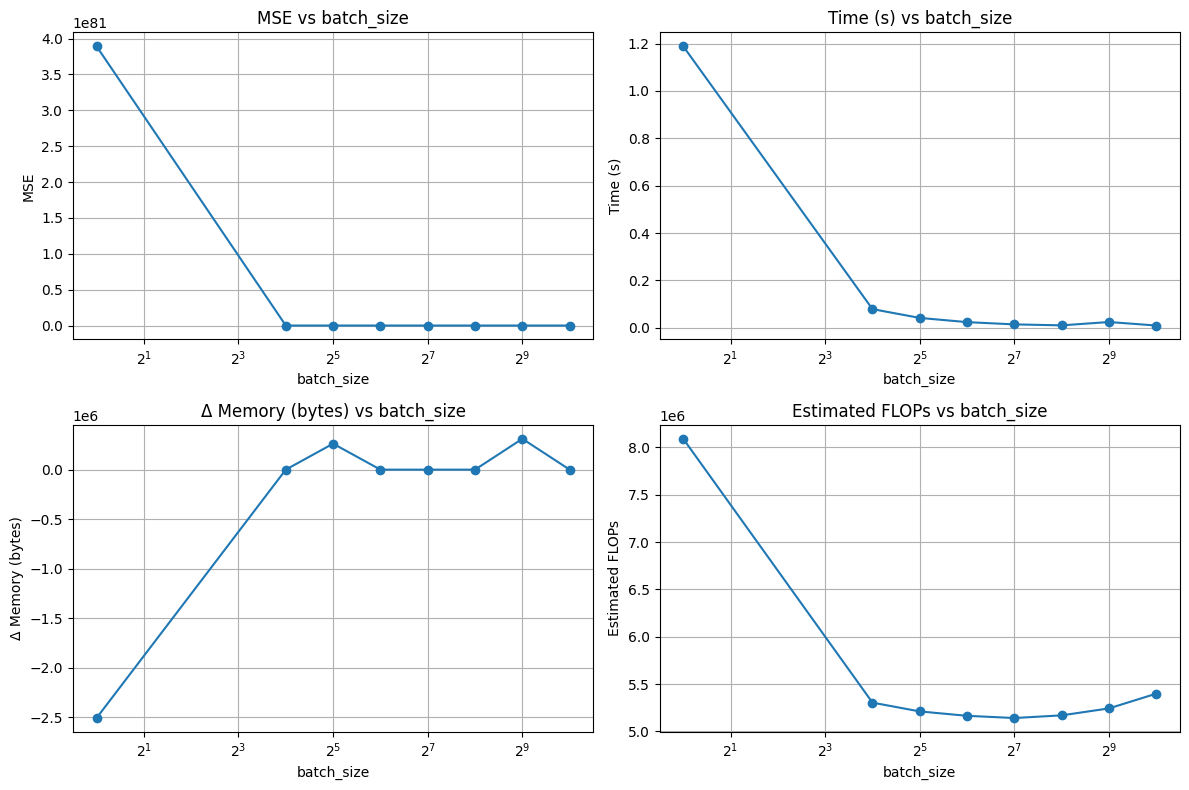

[I 2025-05-20 19:19:21,856] A new study created in memory with name: no-name-9b80d2a8-457c-4114-9755-a2d15c8bc12d


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:23,085] Trial 0 finished with value: 2.483019347910611e+80 and parameters: {}. Best is trial 0 with value: 2.483019347910611e+80.
[I 2025-05-20 19:19:23,183] Trial 1 finished with value: 354.6001974959478 and parameters: {}. Best is trial 1 with value: 354.6001974959478.
[I 2025-05-20 19:19:23,236] Trial 2 finished with value: 0.5470118853894964 and parameters: {}. Best is trial 2 with value: 0.5470118853894964.
[I 2025-05-20 19:19:23,282] Trial 3 finished with value: 0.5495648868267321 and parameters: {}. Best is trial 2 with value: 0.5470118853894964.
[I 2025-05-20 19:19:23,308] Trial 4 finished with value: 0.5630852644752633 and parameters: {}. Best is trial 2 with value: 0.5470118853894964.
[I 2025-05-20 19:19:23,325] Trial 5 finished with value: 0.5971543993048605 and parameters: {}. Best is trial 2 with value: 0.5470118853894964.
[I 2025-05-20 19:19:23,339] Trial 6 finished with value: 0.6786959788817688 and parameters: {}. Best is trial 2 with value: 0.547011

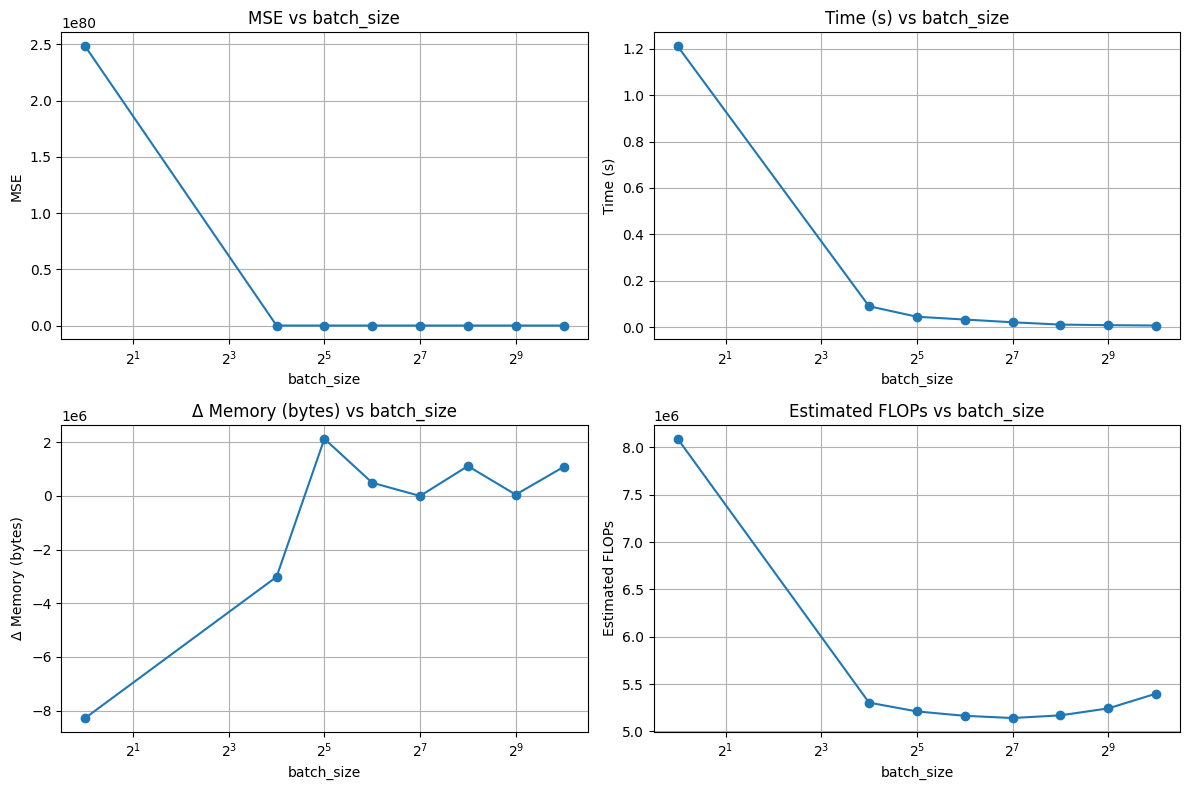

[I 2025-05-20 19:19:25,322] A new study created in memory with name: no-name-525d083f-7d08-4b8b-b365-f6f4b13cd355


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:26,749] Trial 0 finished with value: 4.778113609578892e+87 and parameters: {}. Best is trial 0 with value: 4.778113609578892e+87.
[I 2025-05-20 19:19:26,858] Trial 1 finished with value: 13040.223569355978 and parameters: {}. Best is trial 1 with value: 13040.223569355978.
[I 2025-05-20 19:19:26,918] Trial 2 finished with value: 0.5551980877462593 and parameters: {}. Best is trial 2 with value: 0.5551980877462593.
[I 2025-05-20 19:19:26,952] Trial 3 finished with value: 0.5503040452165766 and parameters: {}. Best is trial 3 with value: 0.5503040452165766.
[I 2025-05-20 19:19:26,979] Trial 4 finished with value: 0.5613700587223346 and parameters: {}. Best is trial 3 with value: 0.5503040452165766.
[I 2025-05-20 19:19:26,996] Trial 5 finished with value: 0.6127882032612552 and parameters: {}. Best is trial 3 with value: 0.5503040452165766.
[I 2025-05-20 19:19:27,008] Trial 6 finished with value: 0.5995137721440879 and parameters: {}. Best is trial 3 with value: 0.5503

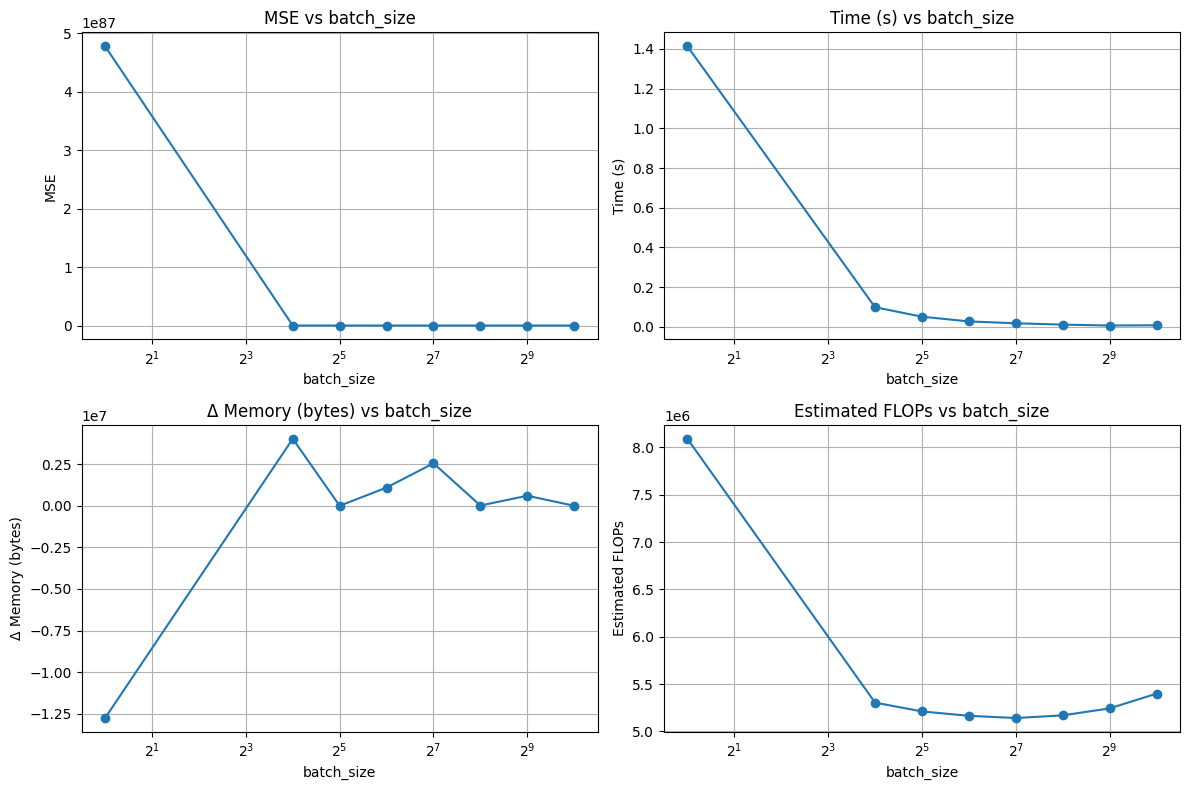

[I 2025-05-20 19:19:28,927] A new study created in memory with name: no-name-589a05e6-ff3c-475a-9def-9234e8a26332


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:30,433] Trial 0 finished with value: 2.0271686860014507e+88 and parameters: {}. Best is trial 0 with value: 2.0271686860014507e+88.
[I 2025-05-20 19:19:30,551] Trial 1 finished with value: 1582.900679333703 and parameters: {}. Best is trial 1 with value: 1582.900679333703.
[I 2025-05-20 19:19:30,626] Trial 2 finished with value: 0.5518833019985615 and parameters: {}. Best is trial 2 with value: 0.5518833019985615.
[I 2025-05-20 19:19:30,683] Trial 3 finished with value: 0.5498131787417593 and parameters: {}. Best is trial 3 with value: 0.5498131787417593.
[I 2025-05-20 19:19:30,718] Trial 4 finished with value: 0.5841260226960453 and parameters: {}. Best is trial 3 with value: 0.5498131787417593.
[I 2025-05-20 19:19:30,734] Trial 5 finished with value: 0.6302231882818532 and parameters: {}. Best is trial 3 with value: 0.5498131787417593.
[I 2025-05-20 19:19:30,749] Trial 6 finished with value: 0.5830765181349304 and parameters: {}. Best is trial 3 with value: 0.5498

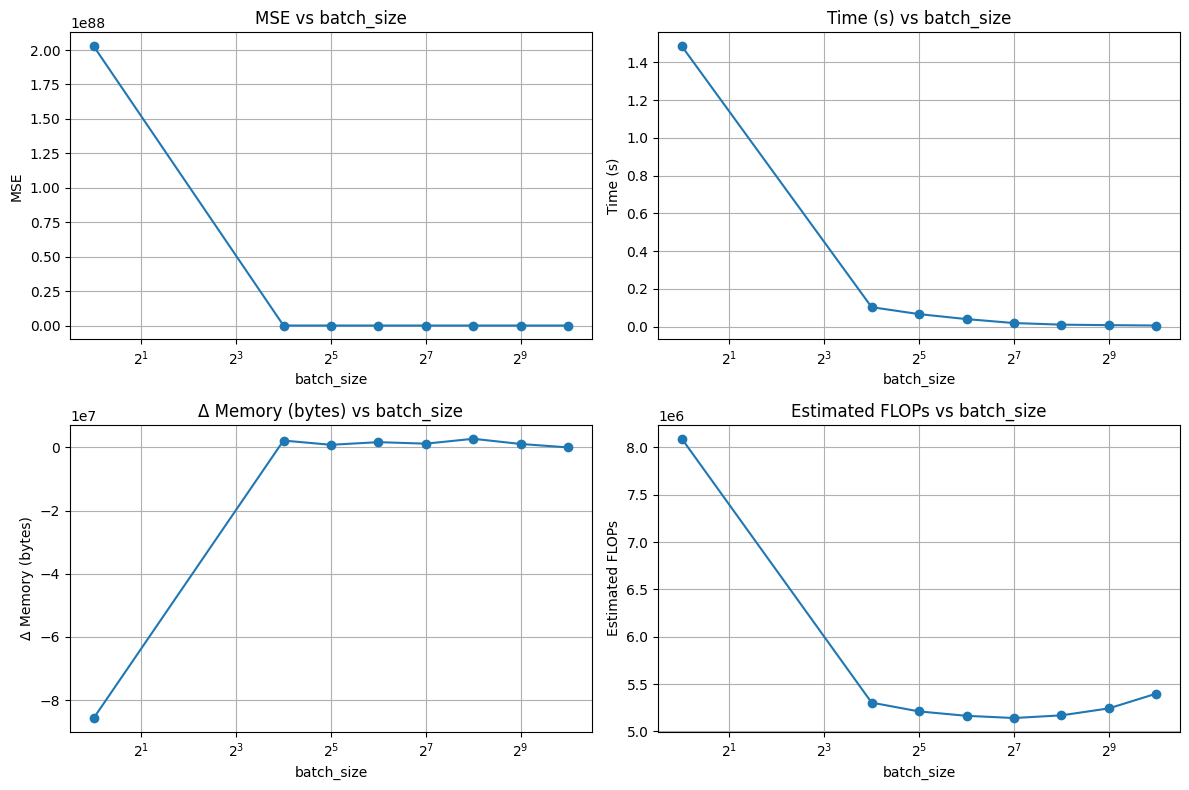

[I 2025-05-20 19:19:32,975] A new study created in memory with name: no-name-1dcca354-370f-47eb-811d-adf7a19bb394


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:34,340] Trial 0 finished with value: 1.9218975238208387e+87 and parameters: {}. Best is trial 0 with value: 1.9218975238208387e+87.
[I 2025-05-20 19:19:34,437] Trial 1 finished with value: 88042.03074603144 and parameters: {}. Best is trial 1 with value: 88042.03074603144.
[I 2025-05-20 19:19:34,488] Trial 2 finished with value: 0.546812836980427 and parameters: {}. Best is trial 2 with value: 0.546812836980427.
[I 2025-05-20 19:19:34,519] Trial 3 finished with value: 0.5489607179117704 and parameters: {}. Best is trial 2 with value: 0.546812836980427.
[I 2025-05-20 19:19:34,539] Trial 4 finished with value: 0.5862070565710777 and parameters: {}. Best is trial 2 with value: 0.546812836980427.
[I 2025-05-20 19:19:34,557] Trial 5 finished with value: 0.5997607007501332 and parameters: {}. Best is trial 2 with value: 0.546812836980427.
[I 2025-05-20 19:19:34,570] Trial 6 finished with value: 0.6600466739846353 and parameters: {}. Best is trial 2 with value: 0.546812836

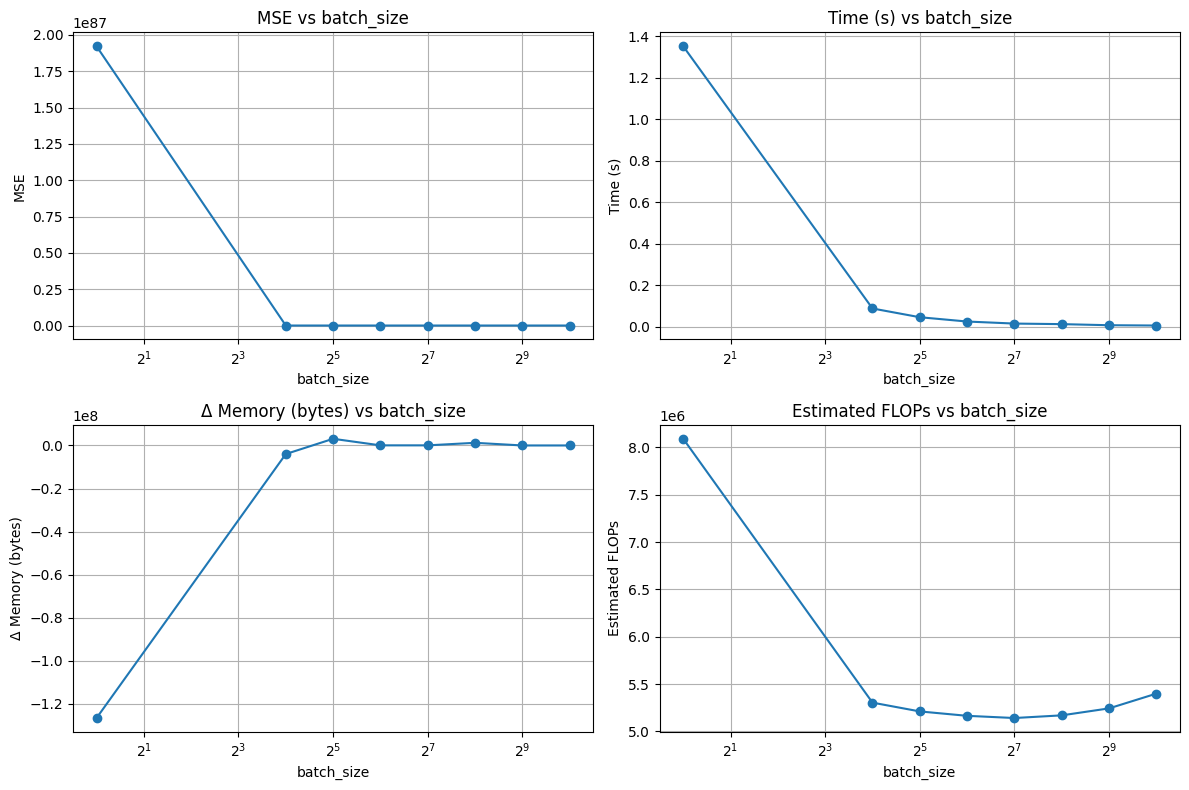

[I 2025-05-20 19:19:36,592] A new study created in memory with name: no-name-3c9ab09d-b1e7-4a2a-9914-99c46071910b


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-20 19:19:39,270] Trial 0 finished with value: 1.193357075037386e+89 and parameters: {}. Best is trial 0 with value: 1.193357075037386e+89.
[I 2025-05-20 19:19:39,399] Trial 1 finished with value: 343.9909737299236 and parameters: {}. Best is trial 1 with value: 343.9909737299236.
[I 2025-05-20 19:19:39,462] Trial 2 finished with value: 0.5747043508199062 and parameters: {}. Best is trial 2 with value: 0.5747043508199062.
[I 2025-05-20 19:19:39,505] Trial 3 finished with value: 0.549478756703736 and parameters: {}. Best is trial 3 with value: 0.549478756703736.
[I 2025-05-20 19:19:39,540] Trial 4 finished with value: 0.5580287592192393 and parameters: {}. Best is trial 3 with value: 0.549478756703736.
[I 2025-05-20 19:19:39,557] Trial 5 finished with value: 0.5679106095016435 and parameters: {}. Best is trial 3 with value: 0.549478756703736.
[I 2025-05-20 19:19:39,574] Trial 6 finished with value: 0.5725382538248363 and parameters: {}. Best is trial 3 with value: 0.5494787567

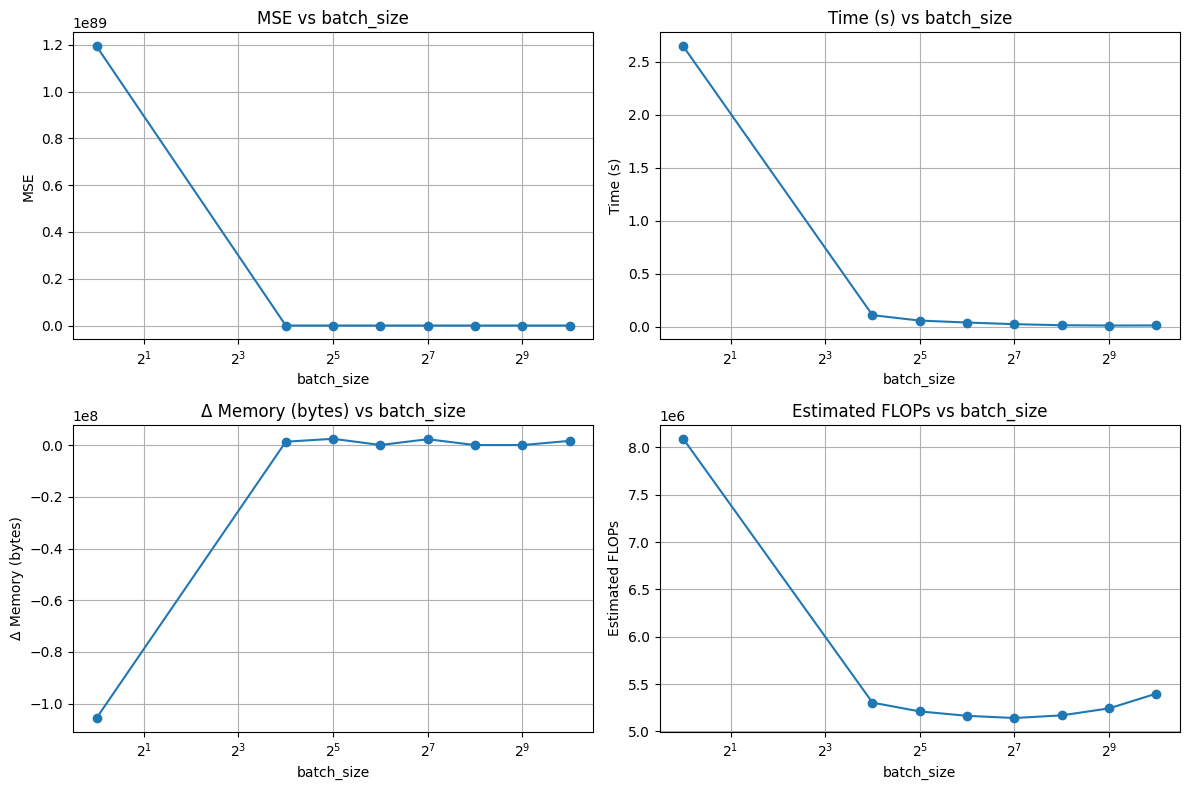

In [4]:
def bench(reg, lrs):
    models = []
    for batch_size in [1, 16, 32, 64, 128, 256, 512, 1024]:
        X, y = load_california(scale=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = SGD(
            learning_rate=0.01,
            epochs=10,
            batch_size=batch_size,
            regularization=reg,
            reg_param=0.01,
            lr_schedule=lrs
        )
        model.fit(X_train, y_train)
        models.append(model)

    plot_performance_metrics(models)

for reg in ['l1', 'l2', 'elasticnet']:
    for lrs in ['constant', 'time_decay', 'step_decay', 'exponential']:
        bench(reg, lrs)